# Object tracking in Python

In this session we will build up a workflow to track pre-detected objects through multiple frames of a timeseries.  The images we will be using are of fluorescently-labelled nuclei and are provided by the [Cell Tracking Challenge](http://celltrackingchallenge.net/).

The session is broken down into eight exercises, each of which will introduce a new step to the workflow.  Typically an exercise will require creation of a new Python function to achieve a specific task (e.g. calculating the cost of linking two points).  The format of each function is laid out in the comments above that function.  It'll be up to you to replace the comment "### CODE GOES HERE ###" with the relevant code.

At the end of each exercise is a pre-prepared block of code ("### TEST SPACE ###") that can be used to test the function is working correctly.  The code in this box doesn't need to be altered to work.

## Exercise 0 - Getting started
Before we start, we need to make sure this Jupyter Notebook has access to all the functions we're going to use later on.  

For the sake of keeping the output on the notebook neat, we'll also set Numpy and Pandas to only display numbers to 2 decimal places (they're still working with higher precision values).  

Finally, we'll also create a variable to represent "infinity".  This will be used later on during the object linking steps.

### Aim
- Import any functions we will use later on
- Set Numpy and Pandas to display numbers to 2 decimal places
- Create an "infinity" variable, which we will use during tracking

### Notes
- This exercise doesn't require addition of any code; all you need do is run the code blocks to check all the libraries import correctly. 

In [1]:
# Importing the libraries into this Notebook
import math
import sys
import util

import numpy as np
import pandas as pd

from scipy.optimize import linear_sum_assignment

In [2]:
# Setting parameters for Jupyter output
np.set_printoptions(precision=2,threshold=sys.maxsize)
pd.options.display.float_format = "{:.2f}".format

In [3]:
# Creating a global variable for "infinity".  This will be needed later on when calculating assignments.
inff = 1000000000

## Exercise 1 - Loading coordinates and visualising
Our key aim this afternoon is to learn about tracking, so we don't want to spend half our time detecting objects to be tracked.  As such, you'll find a pre-prepared CSV file with object coordinates at *../assets/UntrackedCoordinates.csv*.  This file has 6 columns: Point ID, x-centroid, y-centroid, timepoint, 2D area and track ID (currently set to 0).  You will need to download the corresponding images from the Cell Tracking Challenge website [here](http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DH-GOWT1.zip).  Please unzip this archive, then put the contents of folder "01" in the *../assets/images/* folder.

We could also sink a couple of hours into creating a script to draw our object coordinates and tracks, but let's not.  For now, I've created a separate script which will load these files for us - this is in the "util.py" file we just imported.  This script also has functions to display the spots on top of the images, so we can check how our tracking is doing.

### Aims
- Load object coordinates from *../assets/UntrackedCoordinates.csv* into a Pandas dataframe
- Load the timeseries images corresponding to the coordinates into a 3D Numpy array
- Display the first few lines of the coordinate dataframe
- Visualise the coordinates as an overlay on the timeseries images

### Notes
- This exercise also doesn't require any code to be written.  It's more about checking the relevant example files can be loaded and the utility functions run as expected.

In [4]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

Loading images from " ./assets/images/ "

Reading image 92 of 92
Loaded image shape:  (256, 256, 92)
Loading coordinates from " ./assets/UntrackedCoordinates.csv "
Loaded data shape:  (2058, 6)
 
     ID      X      Y  FRAME    AREA  TRACK_ID
0  1.00  19.58  50.83   0.00 4262.00      0.00
1  2.00  37.00 104.25   0.00 2449.00      0.00
2  3.00  48.50  26.25   0.00 2617.00      0.00
3  4.00  59.66 116.87   0.00 3914.00      0.00
4  5.00  80.75 132.75   0.00 1513.00      0.00
5  6.00  86.43 148.67   0.00 1632.00      0.00
6  7.00  99.00  77.75   0.00 1649.00      0.00
7  8.00 108.88 113.00   0.00 1836.00      0.00
8  9.00 108.50 135.50   0.00 1649.00      0.00
9 10.00 109.25 161.62   0.00 1384.00      0.00

Rendering frame 92 of 92

<IPython.core.display.Javascript object>


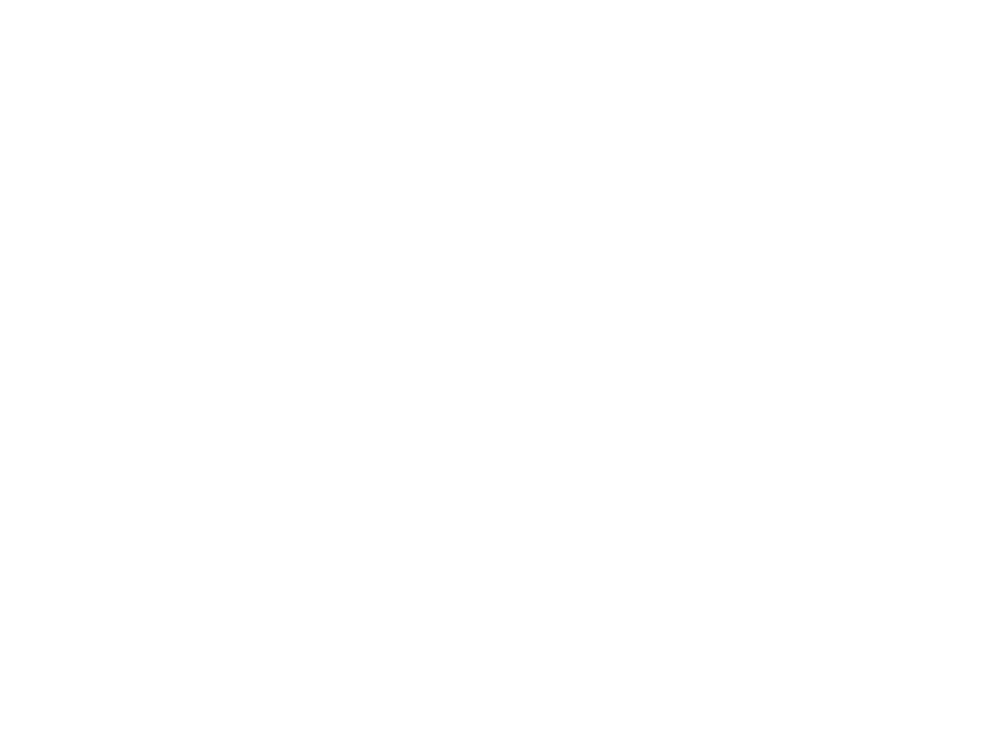

interactive(children=(IntSlider(value=0, description='frame', max=91), Output()), _dom_classes=('widget-intera…

In [5]:
%matplotlib notebook

# Loading image stack
path = "./assets/images/"
images = util.load_images(path);

# Loading coordinates
path = "./assets/UntrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Displaying the first 10 lines of the dataframe
print(coords.head(10))
print("")

# Adding track renders
util.show_overlay(images,coords,False)

## Exercise 2 - Extracting coordinates for a specific timepoint
We now have the full list of coordinates, but for tracking we're often going to want to access just those from a specific frame.  The first function we'll create will take the full list of coordinates and return a list of rows corresponding to only those points in the specified frame.

### Aims
- Create a function to get a list of row indices corresponding to coordinates in a specific frame
- Arguments: The coordinates dataframe and the frame number as arguments
- Return: A list of row indices locating the relevant points in the coordinates dataframe

### Notes
- This is the first exercise where we need to add in some code.  This exercise also follows the standard format that all remaining exercises will use.  In the next box you will need to replace the comment "### CODE GOES HERE ###" with the code for that function.  Above the function you'll find a description of the function format (i.e. the inputs and outputs).  Once the code is ready, you can test it with the next box ("### TEST SPACE ###").  The test space should display the row indices for the first couple of frames.  
- If you wish to further verify these indices are correct, you could open the coordinates csv file in a spreadsheet viewer (e.g. Excel).
- You'll likely want to use Panda's "index" function.  This returns the indices for the rows matching the provided condition.  For example, to get the row indices for all coordinates in frames after frame 7, we could use the following:
```Python
    coord_rows_over_f7 = coords.index[coords.FRAME > 7]
```

In [6]:
# Function to get the row indices for coordinates present in a specific frame.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames.
#     frame: Frame number for which we're getting coordinates.
#
# Returns:
#     A list of indices corresponding to the coordinates for the specified frame
#

def get_current_coords(coords, frame):
    # Identifying rows of "coords" with current frame number
    rows = coords.index[coords.FRAME == frame]

    return rows

In [7]:
### TEST SPACE ### 

# Loading coordinates
path = "./assets/UntrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Testing on coordinates from frame 0
frame = 0
rows_0 = get_current_coords(coords,frame)
print("Row indices for points in frame 0:\n%a\n" % rows_0)

# Testing on coordinates from frame 1
frame = 1
rows_1 = get_current_coords(coords,frame)
print("Row indices for points in frame 1:\n%a\n" % rows_1)

Loading coordinates from " ./assets/UntrackedCoordinates.csv "
Loaded data shape:  (2058, 6)
 
Row indices for points in frame 0:
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22],
           dtype='int64')

Row indices for points in frame 1:
Int64Index([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
            40, 41, 42, 43, 44, 45],
           dtype='int64')



## Exercise 3 - Assign tracks IDs to coordinates in first frame
Eventually, all points will be assigned track IDs.  As we work through all the frames, points will be linked to those in a previous frame and inherit their track IDs.  This way, track ID gets propagated through the timeseries.  To kick things off, we need to assign all points in the first frame unique IDs.  The function we create here will identify any points in a specific frame (for now, frame 0) that don't have assigned track IDs and assign them the smallest, currently unused track ID.  By keeping the function general like this we can reuse it later on when find any points in any frame that didn't get linked back to an existing track.

### Aims
- Assign unique track ID numbers to the rows in the coordinates dataframe ("coords") that match the provided rows
- Arguments: The coordinates dataframe and the row indices to assign track IDs for
- Return: Nothing!  This function will update the input dataframe

### Notes
- This function will update the coordinates dataframe that is passed to the function, so there are no returned values.
- With Pandas you can get the maximum value in a column using the function "max()".  For example, the following will give the maximum x-value in the whole dataframe:

```Python
    max_x_value = coords.X.max()
```

- One way to do this is to loop over all specified rows, checking if the current track ID is "0".  If it is, give it the next available track ID.

In [8]:
# Function to assign unique track ID numbers to any unassigned coordinates at the specified row
# indices.  Unassigned coordinates are identified by a track ID of 0.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames.
#     point_rows: list of row indices for tracks to have track IDs assigned.  All, some or 
#                 none of these may need track IDs assigning.
#
# Returns:
#     This function updates the provided coordinate dataframe, so does not return anything.
#

def assign_new_IDs(coords, point_rows):
    # Getting the maximum track ID present in coords
    max_ID = coords.TRACK_ID.max()
    
    # Iterating over all current points and assigning the next available ID if they're still 0
    for point_row in point_rows:
        if coords.TRACK_ID[point_row] == 0:
            max_ID = max_ID + 1
            coords.TRACK_ID.at[point_row] = max_ID
        

In [9]:
### TEST SPACE ###

# Loading coordinates
path = "./assets/UntrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Getting all points in the first frame
frame = 0
rows_0 = get_current_coords(coords,frame)

# Assigning unique track IDs to all these points
assign_new_IDs(coords,rows_0)

# Displaying the first 30 rows of our coordinate dataframe
print(coords.head(30))

Loading coordinates from " ./assets/UntrackedCoordinates.csv "
Loaded data shape:  (2058, 6)
 
      ID      X      Y  FRAME    AREA  TRACK_ID
0   1.00  19.58  50.83   0.00 4262.00      1.00
1   2.00  37.00 104.25   0.00 2449.00      2.00
2   3.00  48.50  26.25   0.00 2617.00      3.00
3   4.00  59.66 116.87   0.00 3914.00      4.00
4   5.00  80.75 132.75   0.00 1513.00      5.00
5   6.00  86.43 148.67   0.00 1632.00      6.00
6   7.00  99.00  77.75   0.00 1649.00      7.00
7   8.00 108.88 113.00   0.00 1836.00      8.00
8   9.00 108.50 135.50   0.00 1649.00      9.00
9  10.00 109.25 161.62   0.00 1384.00     10.00
10 11.00 125.00  83.00   0.00 1649.00     11.00
11 12.00 127.42 151.96   0.00 1349.00     12.00
12 13.00 129.25 134.50   0.00 1369.00     13.00
13 14.00 132.25 189.88   0.00 1342.00     14.00
14 15.00 143.00   9.50   0.00 1941.00     15.00
15 16.00 158.97 171.23   0.00 2004.00     16.00
16 17.00 159.75 146.00   0.00 1941.00     17.00
17 18.00 169.00 125.50   0.00 1789.00    

## Exercise 4a - Getting all tracks
When assigning track links for each frame, we need to know what tracks are available to link to.  Here, we want to identify the rows corresponding to the most recent instance of each track.

To start with, we're going to consider any track that has existed as being "available".  As such, we just want to get the most recent row of the coordinates dataframe for each track.  In the second half of this exercise (4b) we will introduce a limit to how far back we will search for the most recent instance of each track.

### Aims
- Get a list containing the row indices of the most recent coordinate for each track
- Arguments: The coordinates dataframe
- Return: A list of row indices for the most recent instance of each track

### Notes
- To check our code works it's useful to have some coordinates that have already been tracked.  Therefore, for this exercise, the "coords" dataframe we load has been tracked up to frame 49
- We will need to find the unique track IDs in our coordinates dataframe.  It's possible to get all the unique values in a list using Numpy's "unique" function.  For example, to get the unique values in the list "my_list" we would call:
```Python
    unique_values = np.unique(my_list)
```
- You can get the last element of a list using *-1:* as the index.  For example, the following will create a list containing three numbers, then print the value of the final row (i.e. "21"):

```Python
    demo_array = np.array([42,63,21])
    print("Final element = ",a[-1:])
```

In [10]:
# Function to find the row indices corresponding to the most recent instance of each track.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames.
#
# Returns:
#     A list containing the row indices for the most recent instance of each track.
#

def get_all_tracks(coords):    
    # Getting a list of the unique track IDs in our coordinates dataframe
    unique_IDs = np.unique(coords.TRACK_ID)
    
    # Iterating over each track ID, adding the most recent row index to track_rows
    track_rows = []
    for unique_ID in unique_IDs:
        if unique_ID != 0:
            # Getting rows for all instances of this track
            instances = coords.index[coords.TRACK_ID == unique_ID]    
            
            # Getting most recent instance of this track and appending it to final_rows
            track_rows.append(instances[-1:][0])
                    
    return track_rows

In [11]:
### TEST SPACE ### 

# Loading coordinates
path = "./assets/PartiallyTrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Getting row indices for all available tracks
track_rows = get_all_tracks(coords)

# Displaying the points we have identified
print("Identified %i available tracks" % len(track_rows))
print("")
print(coords.loc[track_rows])

Loading coordinates from " ./assets/PartiallyTrackedCoordinates.csv "
Loaded data shape:  (2058, 6)
 
Identified 27 available tracks

          ID      X      Y  FRAME    AREA  TRACK_ID
1156 1157.00  28.34  34.91  49.00 4214.00      1.00
1159 1160.00  62.69  18.54  49.00 2727.00      2.00
1170 1171.00 141.00   7.25  49.00 1789.00      3.00
1178 1179.00 206.75  43.88  49.00 1694.00      4.00
1163 1164.00 100.50  71.75  49.00 1649.00      5.00
1168 1169.00 125.25  81.50  49.00 1513.00      6.00
1179 1180.00 211.47 187.21  49.00 1101.00      8.00
1177 1178.00 200.75 189.50  49.00  609.00      9.00
1102 1103.00 186.22 202.36  46.00 1409.00     10.00
1127 1128.00 191.75 205.25  47.00  621.00     12.00
1176 1177.00 189.00 192.75  49.00  305.00     14.00
1175 1176.00 185.50 235.25  49.00 1649.00     15.00
376   377.00 109.50 108.50  16.00  145.00     16.00
1169 1170.00 125.25 117.25  49.00 1451.00     18.00
1162 1163.00  91.00 102.50  49.00 1649.00     22.00
1157 1158.00  38.25 103.25  49.00 

## Exercise 4b - Getting all RECENT  tracks
In the first half of this exercise we identified the most recent instance of each track.  However, we may also choose to only allow links to tracks identified within a specific number of frames.  For example, we may not want to allow a point in frame 42 to link back to a track last seen in frame 9.

### Aims
- Repeat the code from Exercise 4a, but only permit links to tracks between the provided values of *start_frame* and *end_frame*
- Arguments: The coordinates dataframe, the start and end frames, between which we will get available tracks
- Return: A list of row indices for the most recent instance of each track

### Notes
- As before, we'll load the partially-tracked coordinates.

In [12]:
# Function to find the row indices corresponding to the most recent instance of each track.
# This will only return row indices for tracks present within a specified frame range.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames
#     start_frame: First frame of range for which tracks are considered "available" for linking to
#     end_frame: Final frame of range for which tracks are considered "available" for linking to.  This
#                will typically be the frame immediately prior to the "current" frame.
#
# Returns:
#     A list containing the row indices for the most recent instance of each available track.
#

def get_available_tracks(coords, start_frame, end_frame):
    # Getting all rows present within the specified time interval
    rows = coords.index[(coords.FRAME >= start_frame) & (coords.FRAME <= end_frame)]
    
    # Getting the most recent instance of this track
    available_rows = []
    unique_IDs = np.unique(coords.TRACK_ID[rows])
    for unique_ID in unique_IDs:
        if unique_ID != 0:
            # Getting rows for all instances of this track
            instances = coords.index[(coords.TRACK_ID == unique_ID) 
                & (coords.FRAME >= start_frame) & (coords.FRAME <= end_frame)]    
            
            # Getting most recent instance of this track and appending it to final_rows
            available_rows.append(instances[-1:][0])
                    
    return available_rows

In [13]:
### TEST SPACE ### 

# Loading coordinates
path = "./assets/TrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Getting row indices for all available tracks
start_frame = 44
end_frame = 49
track_rows = get_available_tracks(coords,start_frame,end_frame)

# Displaying the points we have identified
print("Identified %i available tracks" % len(track_rows))
print("")
print(coords.loc[track_rows])

Loading coordinates from " ./assets/TrackedCoordinates.csv "
Loaded data shape:  (2058, 6)
 
Identified 26 available tracks

          ID      X      Y  FRAME    AREA  TRACK_ID
1156 1157.00  28.34  34.91  49.00 4214.00      1.00
1159 1160.00  62.69  18.54  49.00 2727.00      2.00
1170 1171.00 141.00   7.25  49.00 1789.00      3.00
1178 1179.00 206.75  43.88  49.00 1694.00      4.00
1163 1164.00 100.50  71.75  49.00 1649.00      5.00
1168 1169.00 125.25  81.50  49.00 1513.00      6.00
1179 1180.00 211.47 187.21  49.00 1101.00      8.00
1177 1178.00 200.75 189.50  49.00  609.00      9.00
1102 1103.00 186.22 202.36  46.00 1409.00     10.00
1127 1128.00 191.75 205.25  47.00  621.00     12.00
1176 1177.00 189.00 192.75  49.00  305.00     14.00
1175 1176.00 185.50 235.25  49.00 1649.00     15.00
1169 1170.00 125.25 117.25  49.00 1451.00     18.00
1162 1163.00  91.00 102.50  49.00 1649.00     22.00
1157 1158.00  38.25 103.25  49.00 2617.00     23.00
1158 1159.00  62.19 109.67  49.00 2923.00  

## Exercise 5 - Calculating cost for linking two points
In a couple of steps we will end up with two lists: one for points in the current frame; the other for the most recent point in all available tracks.  Links between the points in the two lists will be assigned based on the cost associated with making that link.  Here, we want to create a function that will calculate the cost associated with two given points.  To start with, we will just calculate the cost as the distance between the two points, but we could also add costs associated with other metrics.  For example, we may want to penalise links which would see the size or intensity of the object change too much.

### Aims
- Calculate the cost for linking two provided coordinates
- Arguments: The coordinates dataframe, the row index for last instance of the track, row index for current point, a distance threshold
- Return: A single, floating point value corresponding to the cost for linking these two points

### Notes
- For this we'll load in the full set of coordinates, but only calculate the cost for the first points in frame 1 and frame 2.
- In this case, the "cost" is simply the straight-line distance between the two points.
- To get the distance between two points we can use the following equation, where x1,y1 and x2,y2 are the xy coordinates of the two points:

```Python
    dx = x1-x2
    dy = y1-y2
    dist = math.sqrt(dx*dx + dy*dy)
```

In [14]:
# Function to calculate the cost of linking two points.  This function simply calculates the cost as 
# the distance between the two points.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames
#     track_row: Row index for the most recent coordinate in a track
#     point_row: Row index for a coordinate in the current frame
#     thresh: Maximum permitted distance between two points.  If points are separated by more than this
#             the cost will be assigned a very large value to ensure a very low probability of the link
#             being assigned by the Munkres algorithm.
#
# Returns:
#     A floating point (decimal) value corresponding to the cost of linking the two specified points.
#

def calculate_cost(coords,track_row,point_row,thresh):
    # Spatial linking (distance between two points)
    dx = coords.X[point_row] - coords.X[track_row]
    dy = coords.Y[point_row] - coords.Y[track_row]
    d = float(math.sqrt(float(dx*dx + dy*dy)))
#     d = math.sqrt(dx*dx + dy*dy)

    # If the two points are separated by more than the linking threshold, set them to infinity ('inf')
    if d > thresh:
        d = inff
    
    return d

In [15]:
### TEST SPACE ### 

# Loading coordinates
path = "./assets/UntrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Let's get the indices for the coordinates in the first frame
rows_0 = get_current_coords(coords,0)

# For this cost calculation we'll just use the first coordinate in this frame
row_0 = rows_0[0]

# Let's take a look at that coordinate
print("Coordinate 1:\n%a\n" % coords.loc[row_0])

# Now, let's do the same for the second frame
rows_1 = get_current_coords(coords,1)
row_1 = rows_1[0]
print("Coordinate 2:\n%a\n" % coords.loc[row_1])

# Calculating the cost of the two points with the threshold set high
thresh = 10;
cost = calculate_cost(coords,row_0,row_1,thresh)
print("Cost = %f (thresh = %f)" % (cost,thresh))

# Now, we'll do the same, but with a lower threshold
thresh = 0.5;
cost = calculate_cost(coords,row_0,row_1,thresh)
print("Cost = %f (thresh = %f)" % (cost,thresh))

Loading coordinates from " ./assets/UntrackedCoordinates.csv "
Loaded data shape:  (2058, 6)
 
Coordinate 1:
ID            1.00
X            19.58
Y            50.83
FRAME         0.00
AREA       4262.00
TRACK_ID      0.00
Name: 0, dtype: float64

Coordinate 2:
ID           24.00
X            20.29
Y            50.70
FRAME         1.00
AREA       4114.00
TRACK_ID      0.00
Name: 23, dtype: float64

Cost = 0.722277 (thresh = 10.000000)
Cost = 1000000000.000000 (thresh = 0.500000)


## Exercise 6 - Calculate cost matrix
Now we can calculate the cost for a single pair of points we need to do it for all point pairs.  We will create a function which takes the points in the current frame and the available track points, then generates a 2D cost matrix.  The cost matrix will have a column for each point in the current frame and a row for each available track.  The value of each element will therefore be the cost of linking the point and track corresponding to that column and row.  We also want to limit the distance that links can be made over; therefore, any point-track pairs separations that are greater than a specific distance will be set to infinity.  This doesn't prevent them being linked (if there are no better options, the assignment algorithm will still suggest that as a link), but it makes it less likely.

Once we have the cost matrix, we can use SciPy's linear_sum_assignment to calculate the optimal assignments.  This step has been included as the final step in the test space.  We will look into the format of the assignment output in more detail as part of exercise 7.

### Aims
- Given two lists containing row indices, the first for the most recent instance of all available tracks and the second for all points in the current frame, calculate a cost matrix.
- Arguments: The coordinates dataframe, the row indices for tracks, row indices for current points, a distance threshold
- Return: An array of floating point values corresponding to the costs for linking all points

### Notes
- The cost matrix will need to be a 2D Numpy array with a row for every available track and a column for every point in the current frame.
- One way to do this is to use nested loops.  "Nesting loops" simply means to put one loop inside another.  The following example has two nested loops, which print their iteration numbers:

```Python
    for i in range(0,3):
        for j in range(7,9):
            print(i,",",j)
``` 
        This will print the following: "0,7", "0,8", "1,7", "1,8", "2,7", "2,8"
    
- When looping over a structure you can use the *enumerate* function get the current iteration index as well as the current value:

```Python
    demo_array = np.array([42,63,21])
    for i,val in enumerate(demo_array):
        print("Iter=%i,value=%i" % (i,val))
```
        This will print "Iter=0,value=42", "Iter=1,value=63", "Iter=2,value=21"

- So we can easily see how this is working, we'll load a special set of coordinates.  This set only has 3 points in the first frame and 4 points in the second frame.

In [16]:
# Function to calculate the cost of linking all points specified by two lists of row indices.  The
# first list of indices corresponds to the most recent coordinates in each available track.  The 
# second list of indices corresponds to the coordinates in the current frame.  Costs are added to a 
# 2D Numpy array.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames
#     track_rows: Row indices for the most recent coordinate in all available tracks
#     point_rows: Row indices for all coordinates in the current frame
#     thresh: Maximum permitted distance between two points.  If points are separated by more than this
#             the cost will be assigned a very large value to ensure a very low probability of the link
#             being assigned by the Munkres algorithm.
#
# Returns:
#     A 2D Numpy array containing all costs.  Each row of the array corresponds to a track and each column
#     to a current coordinate.  The intersection of each row and column is the associated cost.
#

def calculate_cost_matrix(coords,track_rows,point_rows,thresh):
    # Creating the empty array
    costs = np.empty((len(track_rows),len(point_rows)))
        
    # Iterating over each pair, calculating the cost
    for track_i, track_row in enumerate(track_rows):
        for point_i,point_row in enumerate(point_rows):            
            cost = calculate_cost(coords,track_row,point_row,thresh)
            costs[track_i,point_i] = cost
           
    return costs

In [17]:
### TEST SPACE ### 

# Loading coordinates
path = "./assets/TestCoordinatesForCostMatrix.csv"
coords = util.load_coordinates(path);

# Let's get the indices for the coordinates in the first (available tracks) and second (current points) frames
track_rows = get_current_coords(coords,0)
point_rows = get_current_coords(coords,1)

# Calculating the cost matrix
thresh = 20
costs = calculate_cost_matrix(coords,track_rows,point_rows,thresh)

# Displaying our costs
print("Cost matrix:\n%a\n" % costs)

# Using SciPy's linear_sum_assignment solver to get the optimal assignments
assignments = linear_sum_assignment(costs)
print("Assignments:\n%a\n%a\n" % (assignments[0],assignments[1]))

Loading coordinates from " ./assets/TestCoordinatesForCostMatrix.csv "
Loaded data shape:  (7, 6)
 
Cost matrix:
array([[1.03e+00, 1.00e+09, 8.72e+00, 1.62e+01],
       [1.00e+09, 0.00e+00, 1.73e+01, 1.00e+09],
       [8.45e+00, 1.63e+01, 1.45e+00, 1.52e+01]])

Assignments:
array([0, 1, 2], dtype=int64)
array([0, 1, 2], dtype=int64)



## Exercise 7 - Assigning tracks
As we saw at the end of the last exercise (in the test space), the job of calculating the assignments is done using the Munkres (aka. Kuhn-Munkres or Hungarian) algorithm.  Rather than create our own implementation of this, we can use SciPy's linear_sum_assignment function.  This algorithm simply takes the cost matrix we just created and outputs a Nx2 array of assignments, where N is the number of assignments.  For each row of the assignment result the first column value corresponds to the track and the second column to the linked coordinate.  

As mentioned previously, the Munkres algorithm will still assign links that we set to "infinity", so before we copy over any track IDs we want to double check the cost is not infinity.

### Aims
- Using the calculated track-point assignments, apply the relevant track IDs to each point.
- Arguments: The coordinates dataframe, the row indices for the tracks and points to be (potentially) linked, the cost matrix for these tracks and points.
- Return: Nothing!  This function will update the input dataframe

### Notes
- If we were to iterate over the *assignments* array we would receive the first column, then second.  Instead, we want to get the rows one at a time.  We can do this using the *zip* function.
- For this example we'll go back to using the partially-tracked example coordinates.  This dataset has tracks assigned up to frame 49.
- The test space for this exercise uses many of the functions we've created so far: 
    - Getting available tracks
    - Getting coordinates from the current frame
    - Calculating the cost matrix
    - Calculating assignments
    - Inheriting track IDs from assigned tracks
    - Creating new track IDs for unlinked points
- We'll only permit linking to tracks last seen within 3 frames of the current frame.

In [18]:
# Function to assign links between two sets of coordinates based on provided costs.
#
# Args:
#     coords: Pandas dataframe containing all coordinates from all frames
#     track_rows: Row indices for the most recent coordinate in all available tracks
#     point_rows: Row indices for all coordinates in the current frame
#     costs: 2D Numpy array containing all costs.  Each row of the array corresponds to a track and each 
#            column to a current coordinate.  The intersection of each row and column is the associated cost.
#
# Returns:
#     This function updates the provided coordinate dataframe, so does not return anything.
#

def assign_IDs(coords, track_rows, point_rows, costs):
    # Using SciPy's linear_sum_assignment function to assign optimal links
    assignments = linear_sum_assignment(costs)
        
    for track_assignment, point_assignment in zip(assignments[0],assignments[1]):
        # Even though we set disallowed costs to 1000000000, if there are no better options, Munkres will still 
        # assign these. We need to check if the assignment corresponds to one of these disallowed assignments.
        if costs[track_assignment,point_assignment] < inff:
            track_row = track_rows[track_assignment]
            point_row = point_rows[point_assignment]
            
            ID = coords.TRACK_ID[track_row]
            coords.TRACK_ID.at[point_row] = ID

In [19]:
### TEST SPACE ### 

# Loading coordinates
path = "./assets/PartiallyTrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Setting some parameters
frame = 50
frame_thresh = 2
linking_thresh = 5

# Getting available tracks at frame 11.  We'll only allow links back 5 frames
start_frame = frame - frame_thresh
end_frame = frame - 1
track_rows = get_available_tracks(coords,start_frame,end_frame)

# Getting row indices for points in frame 11
point_rows = get_current_coords(coords,frame)

# Calculating cost matrix
costs = calculate_cost_matrix(coords,track_rows,point_rows,linking_thresh)

# Calculating assignments using SciPy's linear_sum_assignment
assign_IDs(coords, track_rows, point_rows, costs)

# Displaying the coordinates for the current frame (with new assigned track IDs)
print("Coordinates after linking:\n%a\n" % coords.loc[point_rows])

# Assigning new track IDs to points that weren't linked
assign_new_IDs(coords,point_rows)
print("Coordinates after new track creation:\n%a\n" % coords.loc[point_rows])

Loading coordinates from " ./assets/PartiallyTrackedCoordinates.csv "
Loaded data shape:  (2058, 6)
 
Coordinates after linking:
          ID      X      Y  FRAME    AREA  TRACK_ID
1180 1181.00  27.59  34.59  50.00 3332.00      1.00
1181 1182.00  38.25 103.38  50.00 2674.00     23.00
1182 1183.00  60.51 109.76  50.00 2961.00     24.00
1183 1184.00  63.86  19.02  50.00 2995.00      2.00
1184 1185.00  78.62 160.75  50.00 1412.00     31.00
1185 1186.00  80.50 133.75  50.00 1789.00     25.00
1186 1187.00  90.75 103.38  50.00 1694.00     22.00
1187 1188.00 100.50  71.75  50.00 1649.00      5.00
1188 1189.00 101.77 170.59  50.00 1326.00     32.00
1189 1190.00 115.00 131.75  50.00 1513.00     26.00
1190 1191.00 118.00 156.25  50.00 1125.00     30.00
1191 1192.00 118.89 194.53  50.00 1142.00     34.00
1192 1193.00 124.62 116.75  50.00 1410.00     18.00
1193 1194.00 125.25  81.50  50.00 1513.00      6.00
1194 1195.00 141.00   7.25  50.00 1789.00      3.00
1195 1196.00 144.75 138.12  50.00 1410.

## Exercise 8 - Putting it all together
We now have all the components necessary to construct a full tracking workflow.  For this, we put most of the components in a single for-loop, which will iterate over each frame.  At the end of this we will re-render the overlay to see if our tracking has worked correctly.  Unlike previous exercises, you don't need to create new functions here - you have everything you need.  The aim is to load the full coordinate set, then iterate over each frame, tracking the coordinates.

### Aims
- Take the various functions you've created over the past few exercises and put them all together, so we can track over all frames.
- At the end of this section you want to end up with the *TRACK_ID* column of the *coords* array completed (i.e. all rows have a relevant ID).

### Notes
- Unlike previous exercises, there are no extra functions to create here.  As such, you'll be adding code direct into the test space.
- You may want to look at the test space for exercise 7 as an example of tracking between two frames.
- There's a final box of code after the test space which will run the pre-prepared plotting tool.  If the tracking has worked, you should see tracked lines over the images.

In [20]:
### TEST SPACE ### 

# First, a bit of housekeeping, so we can display the overlaid tracks later on
%matplotlib notebook

# Setting parameters
np.set_printoptions(precision=3,threshold=sys.maxsize)

linking_thresh = 5
frame_thresh = 3

# Loading image stack
path = "./assets/images/"
images = util.load_images(path);

# Loading coordinates
path = "./assets/UntrackedCoordinates.csv"
coords = util.load_coordinates(path);

# Assigning unique track IDs to points in the first frame
rows_0 = get_current_coords(coords,0)
assign_new_IDs(coords,rows_0)

# Getting the number of frames
n_frames = images.shape[2]

# Starting at frame 2, looping over each frame, linking pairs
for frame in range (1,n_frames):    
    sys.stdout.write("\rProcessing frame %i" % frame)
    
    start_frame = frame - frame_thresh
    end_frame = frame-1
    
    track_rows = get_available_tracks(coords,start_frame,end_frame)

    # Getting row indices for points in current frame
    point_rows = get_current_coords(coords,frame)

    # Calculating cost matrix
    thresh = 10
    costs = calculate_cost_matrix(coords,track_rows,point_rows,thresh)

    # Calculating assignments using SciPy's linear_sum_assignment
    assign_IDs(coords, track_rows, point_rows, costs)

    # Assigning new track IDs to points that weren't linked
    assign_new_IDs(coords,point_rows)

Loading images from " ./assets/images/ "

Reading image 92 of 92
Loaded image shape:  (256, 256, 92)
Loading coordinates from " ./assets/UntrackedCoordinates.csv "
Loaded data shape:  (2058, 6)
 
Processing frame 91

Rendering frame 92 of 92

<IPython.core.display.Javascript object>


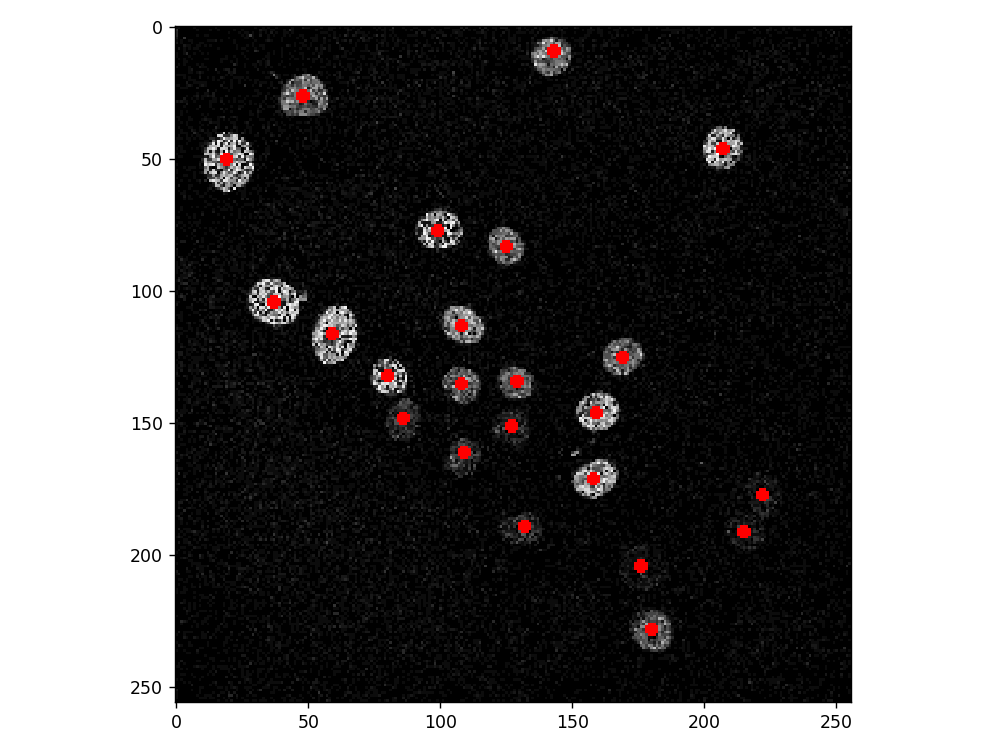

interactive(children=(IntSlider(value=0, description='frame', max=91), Output()), _dom_classes=('widget-intera…

In [21]:
# Adding track renders
util.show_overlay(images,coords,True)